# Podešavanje Sparka za rad u Google Colabu

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyspark

     |████████████████████████████████| 212.4 MB 61 kB/s 
     |████████████████████████████████| 198 kB 54.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=746bcc721d6d08f3e8a4f5524289c73282a200739bd94e177e9c9a3664752806
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


#Učitavanje potrebnih biblioteka

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as f

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure

from pyspark.sql.types import IntegerType

#Analiza i priprema podataka



In [4]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
dataset = spark.read.csv('/content/drive/MyDrive/AVP projekat/aac_shelter_outcomes.csv', header = True)
dataset.show()


+----------------+---------+-----------+--------------------+-------------------+-------------------+-------------------+-------------------+-----------+---------------+---------------+----------------+
|age_upon_outcome|animal_id|animal_type|               breed|              color|      date_of_birth|           datetime|          monthyear|       name|outcome_subtype|   outcome_type|sex_upon_outcome|
+----------------+---------+-----------+--------------------+-------------------+-------------------+-------------------+-------------------+-----------+---------------+---------------+----------------+
|         2 weeks|  A684346|        Cat|Domestic Shorthai...|       Orange Tabby|2014-07-07T00:00:00|2014-07-22T16:04:00|2014-07-22T16:04:00|       null|        Partner|       Transfer|     Intact Male|
|          1 year|  A666430|        Dog|          Beagle Mix|        White/Brown|2012-11-06T00:00:00|2013-11-07T11:47:00|2013-11-07T11:47:00|       Lucy|        Partner|       Transfer|   

In [5]:
dataset.printSchema()

root
 |-- age_upon_outcome: string (nullable = true)
 |-- animal_id: string (nullable = true)
 |-- animal_type: string (nullable = true)
 |-- breed: string (nullable = true)
 |-- color: string (nullable = true)
 |-- date_of_birth: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- monthyear: string (nullable = true)
 |-- name: string (nullable = true)
 |-- outcome_subtype: string (nullable = true)
 |-- outcome_type: string (nullable = true)
 |-- sex_upon_outcome: string (nullable = true)



In [6]:
#analiza
dataForAnalysis = dataset.filter(f.lower(dataset.animal_type).like("%dog%"))\
                                 .select("age_upon_outcome","breed", "color", "sex_upon_outcome", "outcome_type")
                          
dataForAnalysis.show(10)


+----------------+--------------------+-----------+----------------+---------------+
|age_upon_outcome|               breed|      color|sex_upon_outcome|   outcome_type|
+----------------+--------------------+-----------+----------------+---------------+
|          1 year|          Beagle Mix|White/Brown|   Spayed Female|       Transfer|
|          1 year|            Pit Bull| Blue/White|   Neutered Male|       Adoption|
|         9 years|Miniature Schnauz...|      White|   Neutered Male|       Transfer|
|        4 months|      Leonberger Mix|Brown/White|     Intact Male|       Transfer|
|         3 years|Chihuahua Shortha...|      Brown|   Spayed Female|       Transfer|
|         2 years|Papillon/Border C...|Black/White|   Neutered Male|       Transfer|
|        2 months|Chihuahua Shortha...|      Black|   Neutered Male|       Adoption|
|         4 years|Miniature Schnauz...|      White|   Spayed Female|Return to Owner|
|         8 years|Labrador Retrieve...|      Black|   Neutered Ma

In [7]:
print("Broj instanci u skupu podataka: ", dataForAnalysis.count())
dataForAnalysis = dataForAnalysis.dropDuplicates()
print("Broj instanci nakon uklanjanja duplikata: ", dataForAnalysis.count())
dataForAnalysis = dataForAnalysis.dropna(how='any')
print("Broj instanci nakon uklanjanja NULL vrednosti: ", dataForAnalysis.count())

Broj instanci u skupu podataka:  44242
Broj instanci nakon uklanjanja duplikata:  29798
Broj instanci nakon uklanjanja NULL vrednosti:  29794


# Vizuelizacija podataka

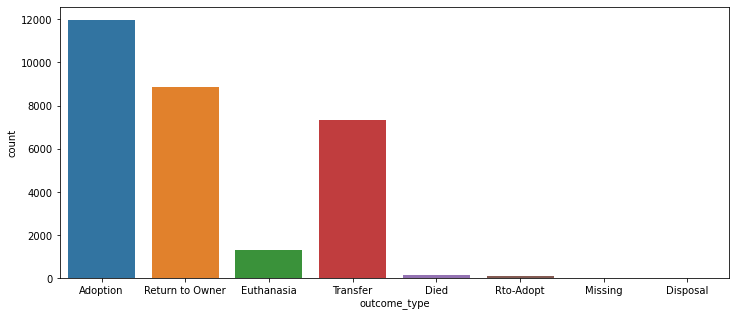

In [8]:
dataPandas = dataForAnalysis.toPandas()
plt.figure(figsize=(12,5))
sns.countplot(data=dataPandas, x='outcome_type')
plt.show()

In [9]:
def adoption(x): 
    x = str(x)   
    if x.find('Adoption') != -1:   
        return 0   
    else: 
        return 1                   

dataPandas['outcome'] = dataPandas['outcome_type'].apply(adoption)

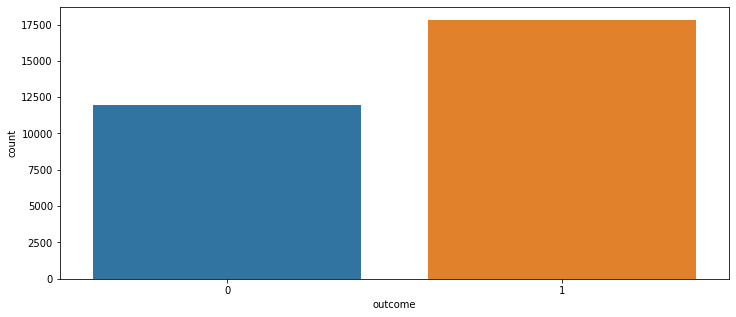

In [10]:

plt.figure(figsize=(12,5))
sns.countplot(data=dataPandas, x='outcome')
plt.show()

In [11]:
#kolona age je tipa string, mi zelimo da bude int
#koristimo years da odredimo koliko godina ima zivotinja, ukoliko pise nesto drugo zivotinja nema godinu dana i njena vrednost je 0

def years_old(x): 
    x = str(x)   
    if x.find('year') != -1:   
        return int(x.split()[0])   
    else: 
        return 0                   

dataPandas['years'] = dataPandas['age_upon_outcome'].apply(years_old)


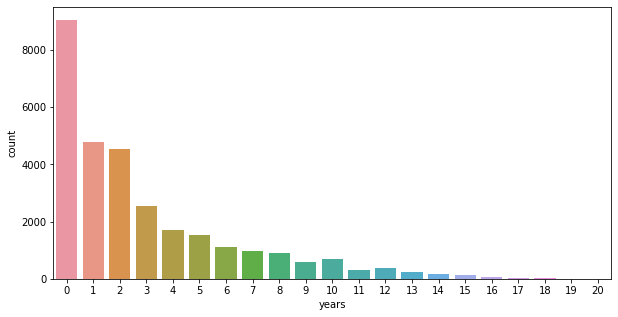

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(data=dataPandas, x='years')
plt.show()

In [13]:
def age_category(x):    
    if x < 1: return 'young'
    elif x < 10: return 'adult'
    else: return 'old'
dataPandas['age'] = dataPandas['years'].apply(age_category)

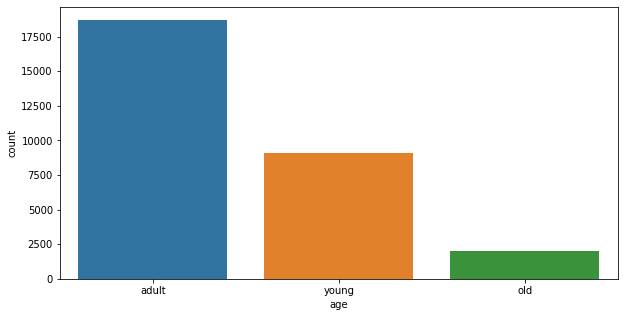

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(data=dataPandas, x='age')
plt.show()

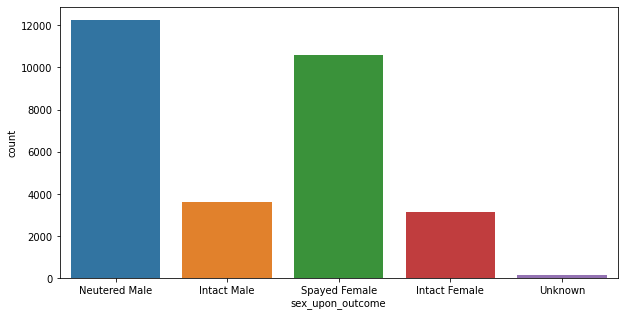

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(data=dataPandas, x='sex_upon_outcome')
plt.show()

In [16]:
breed1 = dataPandas.breed.value_counts()
breed1

Pit Bull Mix                      2486
Chihuahua Shorthair Mix           2357
Labrador Retriever Mix            1907
German Shepherd Mix               1021
Australian Cattle Dog Mix          792
                                  ... 
Collie Smooth/Saluki                 1
Black/Tan Hound/Siberian Husky       1
Boxer/Chow Chow                      1
Pit Bull/Belgian Malinois            1
Golden Retriever/Whippet             1
Name: breed, Length: 1893, dtype: int64

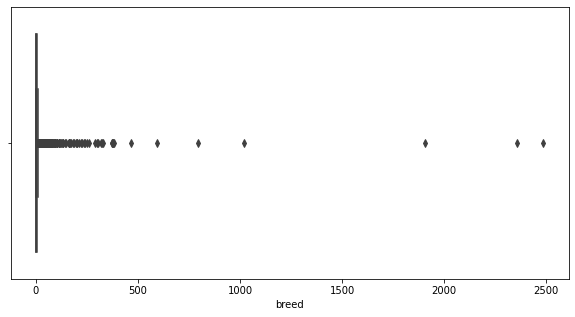

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(x = dataPandas.breed.value_counts() , data = dataPandas)
plt.show()

In [18]:
color1 = dataPandas.color.value_counts()
color1

Black/White              2644
White                    1540
Brown/White              1461
Tan/White                1461
Tricolor                 1381
                         ... 
Chocolate/Gray              1
Brown/Brown Merle           1
White/Brown Tiger           1
Tan/Yellow Brindle          1
Black Smoke/Blue Tick       1
Name: color, Length: 336, dtype: int64

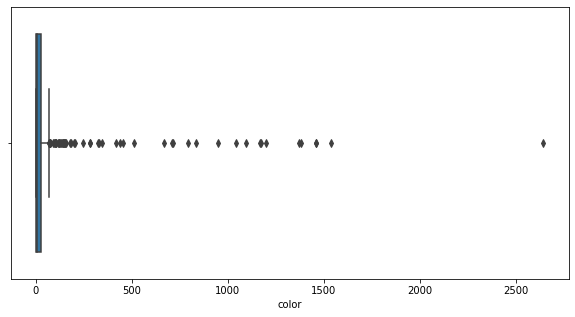

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(x = dataPandas.color.value_counts() , data = dataPandas)
plt.show()

In [20]:
dataPandas.drop(['age_upon_outcome', 'years'], axis='columns', inplace=True)
dataPandas.head()

,breed,color,sex_upon_outcome,outcome_type,outcome,age
0,Staffordshire Mix,Chocolate/White,Neutered Male,Adoption,0,adult
1,Australian Cattle Dog Mix,Red/Red Tick,Intact Male,Return to Owner,1,young
2,Chihuahua Shorthair Mix,Black,Neutered Male,Adoption,0,young
3,Maltese/Yorkshire Terrier,White/Cream,Spayed Female,Adoption,0,adult
4,Flat Coat Retriever/German Shepherd,Black/Brown,Neutered Male,Adoption,0,adult


In [21]:
Analysis = spark.createDataFrame(dataPandas) 

In [22]:
Analysis.printSchema()

root
 |-- breed: string (nullable = true)
 |-- color: string (nullable = true)
 |-- sex_upon_outcome: string (nullable = true)
 |-- outcome_type: string (nullable = true)
 |-- outcome: long (nullable = true)
 |-- age: string (nullable = true)



In [23]:
Analysis = Analysis.withColumn("outcome",Analysis["outcome"].cast(DoubleType()))

In [24]:
Analysis.printSchema()

root
 |-- breed: string (nullable = true)
 |-- color: string (nullable = true)
 |-- sex_upon_outcome: string (nullable = true)
 |-- outcome_type: string (nullable = true)
 |-- outcome: double (nullable = true)
 |-- age: string (nullable = true)



# Treniranje modela

In [25]:
#kreiraćemo estimator da pretvorimo kategoricke vrednosti za breed, color, sex_upon_outcome i age u numeričke
from pyspark.ml.feature import StringIndexer

ageindexer = StringIndexer(inputCol="age",outputCol="ageNum")
breedindexer = StringIndexer(inputCol="breed",outputCol="breedNum")
colorindexer = StringIndexer(inputCol="color",outputCol="colorNum")
sexindexer = StringIndexer(inputCol="sex_upon_outcome",outputCol="sexNum")
#outcomeindexer = StringIndexer(inputCol="outcome_type",outputCol="outcomeNum")


In [26]:
Analysis = ageindexer.fit(Analysis).transform(Analysis)
Analysis = breedindexer.fit(Analysis).transform(Analysis)
Analysis = colorindexer.fit(Analysis).transform(Analysis)
Analysis = sexindexer.fit(Analysis).transform(Analysis)
#Analysis = outcomeindexer.fit(Analysis).transform(Analysis)


In [27]:
#kreiraćemo estimator da kolonu  breedNum i colorNum pretvorimo u niz 0 i 1 
from pyspark.ml.feature import OneHotEncoder

onehot = OneHotEncoder(inputCols=["ageNum", "breedNum","colorNum", "sexNum"],outputCols=["ageVec", "breedVec","colorVec", "sexVec"]) 


In [28]:
Analysis = onehot.fit(Analysis).transform(Analysis)

In [29]:
#kreiramo transformer da kolone skupimo  u jedan vektor
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["ageVec", "breedVec","colorVec", "sexVec"], outputCol="features")

In [39]:
finalData = Analysis.drop('age', 'breed', 'color', 'sex')

finalData.show(20)

+----------------+---------------+-------+------+--------+--------+------+-------------+------------------+-----------------+-------------+
|sex_upon_outcome|   outcome_type|outcome|ageNum|breedNum|colorNum|sexNum|       ageVec|          breedVec|         colorVec|       sexVec|
+----------------+---------------+-------+------+--------+--------+------+-------------+------------------+-----------------+-------------+
|   Neutered Male|       Adoption|    0.0|   0.0|    21.0|    20.0|   0.0|(2,[0],[1.0])| (1892,[21],[1.0])| (335,[20],[1.0])|(4,[0],[1.0])|
|     Intact Male|Return to Owner|    1.0|   1.0|     4.0|   197.0|   2.0|(2,[1],[1.0])|  (1892,[4],[1.0])|(335,[197],[1.0])|(4,[2],[1.0])|
|   Neutered Male|       Adoption|    0.0|   1.0|     1.0|     5.0|   0.0|(2,[1],[1.0])|  (1892,[1],[1.0])|  (335,[5],[1.0])|(4,[0],[1.0])|
|   Spayed Female|       Adoption|    0.0|   0.0|   328.0|    54.0|   1.0|(2,[0],[1.0])|(1892,[328],[1.0])| (335,[54],[1.0])|(4,[1],[1.0])|
|   Neutered Male|  

In [31]:
#kreiramo estimator koji predstavlja algoritam mašinskog učenja
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier

random = RandomForestClassifier(featuresCol="features",labelCol="outcome")
logistic = LogisticRegression(featuresCol="features",labelCol="outcome", maxIter=10)
tree = DecisionTreeClassifier(featuresCol="features",labelCol="outcome")

In [32]:
#kreiramo Pipeline
from pyspark.ml import Pipeline

pipeline_random = Pipeline(stages=[assembler,random])
pipeline_log = Pipeline(stages=[assembler,logistic])
pipeline_tree = Pipeline(stages=[assembler,tree])


In [40]:
#podelićemo podatke na trening i test skup
splits = finalData.randomSplit([0.8,0.2])
train = splits[0]
test = splits[1]
print("Broj vrsta u treningu ",str(train.count()))
print("Broj vrsta u testu ",str(test.count()))

Broj vrsta u treningu  23631
Broj vrsta u testu  6163


In [41]:
#RandomForest
model_random = pipeline_random.fit(train)
prediction_random = model_random.transform(test)

#Logistic
model_log = pipeline_log.fit(train)
prediction_log = model_log.transform(test)

#Linear
model_tree = pipeline_tree.fit(train)
prediction_tree = model_tree.transform(test)

# Evaluacija modela

In [42]:
#evaluacija modela BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="outcome")
print("Metrika RandomForestClassifier: ",evaluator.getMetricName() , " ", evaluator.evaluate(prediction_random))

print("Metrika LogisticRegression: ",evaluator.getMetricName(), " ", evaluator.evaluate(prediction_log))

print("Metrika DecisionTreeClassifier: ",evaluator.getMetricName(), " ", evaluator.evaluate(prediction_tree))


Metrika RandomForestClassifier:  areaUnderROC   0.6944031218512405
Metrika LogisticRegression:  areaUnderROC   0.7372135854147365
Metrika DecisionTreeClassifier:  areaUnderROC   0.5431429351252544


In [57]:
#evaluacija modela CrossValidator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder

rgrid = ParamGridBuilder().addGrid(random.maxDepth, [5, 10, 15]).addGrid(random.numTrees, [5, 10, 15, 20]).build()
cv1 = CrossValidator(estimator=pipeline_random, estimatorParamMaps=rgrid, evaluator=evaluator, numFolds =5, parallelism=2)
model_1 = cv1.fit(train)
prediction_1 = model_1.transform(test)
print("RandomForestClassifier - Cross Validation:", evaluator.getMetricName(), ":", evaluator.evaluate(prediction_1))



RandomForestClassifier - Cross Validation: areaUnderROC : 0.7430372623684711


In [58]:
lgrid = ParamGridBuilder().addGrid(logistic.regParam, [0.1, 0.01]).addGrid(logistic.maxIter, [1, 10]).build()
cv2 = CrossValidator(estimator=pipeline_log, estimatorParamMaps=lgrid, evaluator=evaluator, numFolds =5, parallelism=2)
model_2 = cv2.fit(train)
prediction_2 = model_2.transform(test)
print("LogisticRegression - Cross Validation:", evaluator.getMetricName(), ":", evaluator.evaluate(prediction_2))

LogisticRegression - Cross Validation: areaUnderROC : 0.7381627567526373


In [59]:
tgrid = ParamGridBuilder().addGrid(tree.maxDepth, [5, 10, 15]).build()
cv3 = CrossValidator(estimator=pipeline_tree, estimatorParamMaps=tgrid, evaluator=evaluator, numFolds =5, parallelism=2)
model_3 = cv3.fit(train)
prediction_3 = model_3.transform(test)
print("DecisionTreeClassifier - Cross Validation:", evaluator.getMetricName(), ":", evaluator.evaluate(prediction_3))

DecisionTreeClassifier - Cross Validation: areaUnderROC : 0.5709321495869796


7. Cuvanje modela

In [60]:
model_log.save("/content/gdrive/My Drive/Colab Notebooks/model log")
pipeline_log.save("/content/gdrive/My Drive/Colab Notebooks/pipeline log")

In [61]:
model_1.save("/content/gdrive/My Drive/Colab Notebooks/model random")
pipeline_random.save("/content/gdrive/My Drive/Colab Notebooks/pipeline random")